<a href="https://colab.research.google.com/github/toheedakhtar/pytorch-deeplearning/blob/main/notebooks/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
what_we_are_covering = {
    1: "data (prepare and laod)",
    2: "build model",
    3: "fitting model to data (training)",
    4: "making predictions and evaluating a model",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [77]:
what_we_are_covering

{1: 'data (prepare and laod)',
 2: 'build model',
 3: 'fitting model to data (training)',
 4: 'making predictions and evaluating a model',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [78]:
import torch
from torch import nn # nn contains all of pytorch building blocks for neural networks
import matplotlib.pyplot as plt

torch.__version__

'2.4.1+cu121'

## 1. Data (preparing and loading)

Data can be almost anything.

* excel spreadsheet
* images
* videos
* audio
* dna
* text

Machine learning is a game of two parts,  
1. Get data into a numerical representation  
2. Build a model to learn patterns in that numerical presentation.


In [79]:
# create known parameters
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X  = torch.arange(start, end, step).unsqueeze(dim=1)  # adds 1 dimension
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

In [80]:
# splitting data into train and test sets.
train_split = int(.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?  
This is where the data explorer's motto comes in!  
"Visulize, visualize, visualize!"

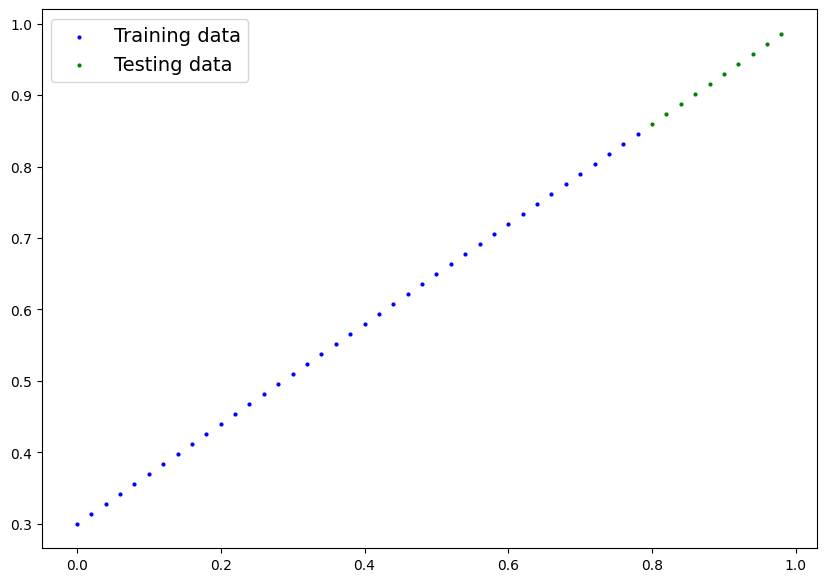

In [6]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):
  """
  Plots training data, test data, and compares predictions
  """
  plt.figure(figsize=(10,7))

  # train data in blue
  plt.scatter(train_data, train_labels, c='b', s=4, label="Training data")

  # test data in green
  plt.scatter(test_data, test_labels, c='g', s=4, label="Testing data")

  # are there predictions?
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c='r', label='Predictions')

  # show the legend
  plt.legend(prop={"size":14})

plot_predictions()


## 2. Build Model

In [82]:
# linear regression
class LinearRegressionModel(nn.Module): # <- almost everything in pytorch inherits nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

   # forward method to define computation in model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # x is input data
    return self.weights * x + self.bias


### Pytorch model building essesntials
* torch.nn - contains all of the building blocks for computational graphs / neural networks
* torch.nn.Parameter - what parameters should our model try and learn. often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - base class for all nerual network modules, if you subclass it , u should overwrite forward()
* torch.optim - this where the optimizer in PyTorch live, will help with Gradient Descent,
* forward() - different for every model

### checking contents of our pyTorch models.

In [83]:
torch.randn(1)

tensor([0.2345])

In [84]:
torch.manual_seed(42)

# create an instance of model
model_0 = LinearRegressionModel()
model_0

LinearRegressionModel()

In [85]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [86]:
# list named parameter
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

In [87]:
# make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

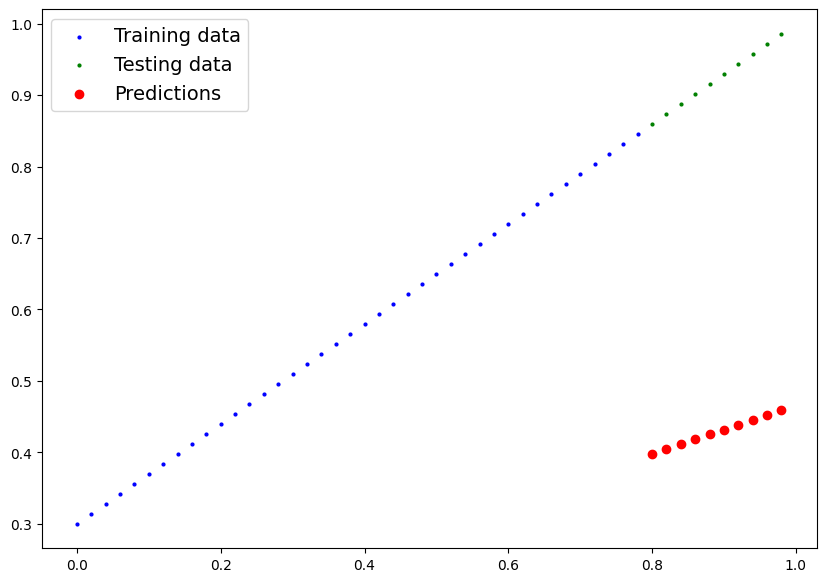

In [88]:
 plot_predictions(predictions=y_preds)

Things we need to train:  
* loss function : A function to measure how wrong your model's prediction are,
* Optimizer : Takes into account loss of a moel and adjusts the model's parameters

Specifically for PyTorch we need,  
* a training loop
* a testing loop

In [89]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [90]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [91]:
# setup a loss function
loss_fn = nn.L1Loss()

# setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [92]:
loss_fn

L1Loss()

### Building a training loop

0. Loop through the data
1. Forward pass
2. Calculate loos
3. Optimizer zero grad
4. Loss backward ( **backprop** )
5. Optimizer step ( **gradient descent**)

In [93]:
# an epoch is one loop
epochs = 200

epoch_count = []
train_loss_values = []
test_loss_values = []

# 0. loop thorugh the data
for epoch in range(epochs):
  model_0.train()  # calc grads of all parameters that require grads

  # 1. Forward Pass
  y_pred = model_0(X_train)

  # 2. calc the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Backpropogation
  loss.backward()

  # 5. Step the optimizer (perform Gradient descent)
  optimizer.step()

  # Testing
  model_0.eval()  # turns off different settings in the model not needed for evaluation / testing
  with torch.inference_mode():
    test_pred = model_0(X_test)
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    train_loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"epoch : {epoch} | loss : {loss} | test_loss : {test_loss}")
    print(model_0.state_dict())


epoch : 0 | loss : 0.31288138031959534 | test_loss : 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
epoch : 10 | loss : 0.1976713240146637 | test_loss : 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
epoch : 20 | loss : 0.08908725529909134 | test_loss : 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
epoch : 30 | loss : 0.053148526698350906 | test_loss : 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
epoch : 40 | loss : 0.04543796554207802 | test_loss : 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
epoch : 50 | loss : 0.04167863354086876 | test_loss : 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
epoch : 60 | loss : 0.03818932920694351 | test_loss : 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('

In [94]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)


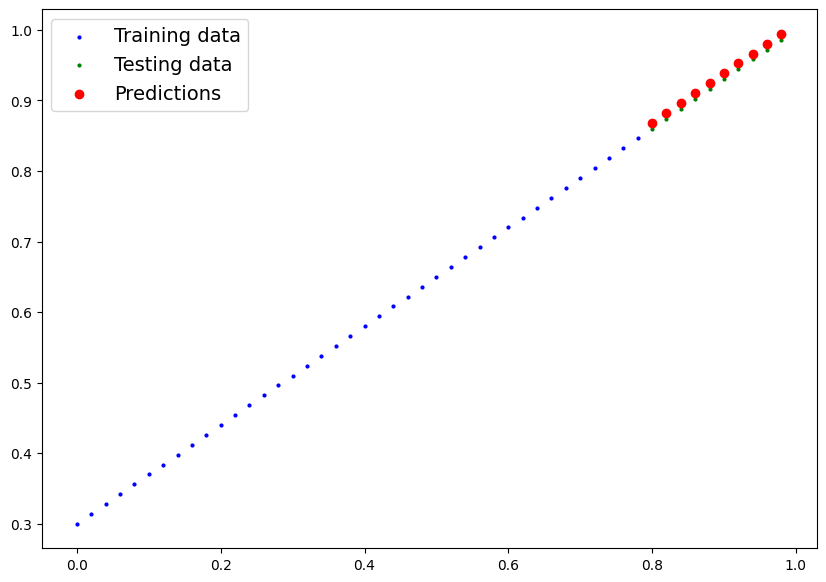

In [95]:
plot_predictions(predictions=y_preds_new)

In [96]:
import numpy as np
np.array(torch.tensor(train_loss_values).numpy()) , test_loss_values

(array([0.31288138, 0.19767132, 0.08908726, 0.05314853, 0.04543797,
        0.04167863, 0.03818933, 0.0347609 , 0.03132383, 0.0278874 ,
        0.02445896, 0.02102021, 0.01758547, 0.01415539, 0.01071659,
        0.00728353, 0.00385178, 0.00893248, 0.00893248, 0.00893248],
       dtype=float32),
 [tensor(0.4811),
  tensor(0.3464),
  tensor(0.2173),
  tensor(0.1446),
  tensor(0.1136),
  tensor(0.0992),
  tensor(0.0889),
  tensor(0.0806),
  tensor(0.0723),
  tensor(0.0647),
  tensor(0.0565),
  tensor(0.0482),
  tensor(0.0406),
  tensor(0.0323),
  tensor(0.0241),
  tensor(0.0165),
  tensor(0.0082),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050)])

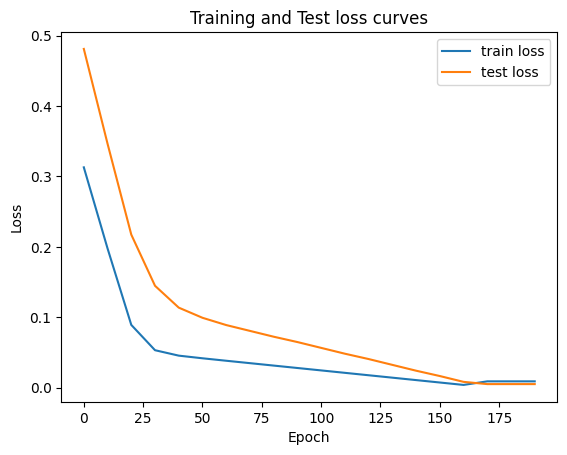

In [97]:
#plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(train_loss_values).numpy()), label="train loss")
plt.plot(epoch_count, test_loss_values, label="test loss")
plt.title("Training and Test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()


## Saving a model in pytorch

three main methods :
1. `torch.save()` : allows to save pytorch object in python's pickle file.
2. `torch.load()` : allows to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - allows to load a model's saved state dictionary.

In [100]:
## saving our model
from pathlib import Path

# create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# create a model save path
MODEL_NAME = '01_pytorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# save the model's state dict
print(f"saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f = MODEL_SAVE_PATH)

saving model to : models/01_pytorch_workflow_model_0.pth


In [98]:
model_0

LinearRegressionModel()

In [101]:
ls -l models

total 4
-rw-r--r-- 1 root root 1680 Sep 27 13:17 01_pytorch_workflow_model_0.pth


## Loading a Pytorch model
Since we saved our model's `state_dict()` rather the entire model, we'll create  
a new instance of our model class and load the save `state_dict()` into that

In [107]:
# laod saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# load the saved state_dict of the model_0 (this will update new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<ipython-input-107-f3e2f7cbd312>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [108]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [110]:
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [111]:
y_preds == loaded_model_preds

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]])

In [112]:
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [113]:
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

putting it all together

create device-agnostic code.  
this means if we've got access to a GPU our code will use it.

In [32]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [33]:
# setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else "cpu"
print(f"Using device : {device}")

Using device : cuda


### 6.1 Data

In [34]:
# create known parameters
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X  = torch.arange(start, end, step).unsqueeze(dim=1)  # adds 1 dimension
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

In [35]:
# splitting data into train and test sets.
train_split = int(.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

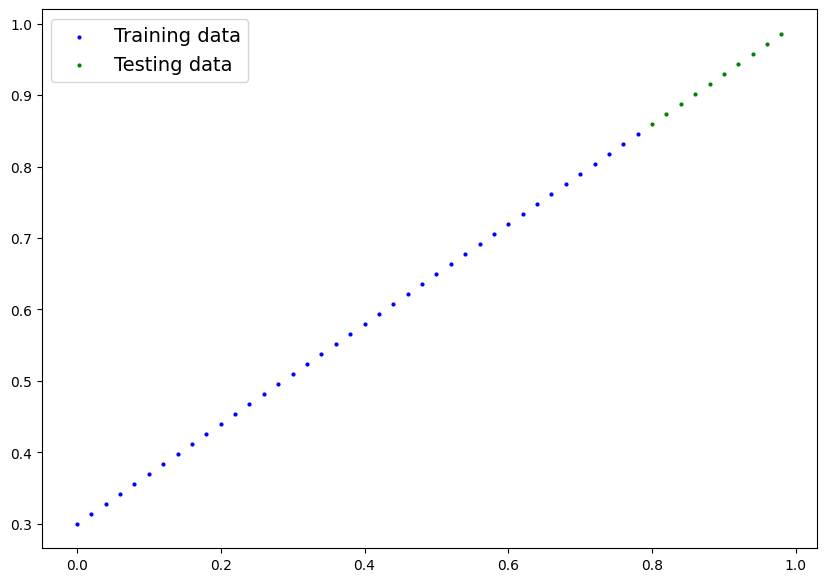

In [36]:
plot_predictions(X_train, y_train, X_test, y_test)


### 6.2 Building a PyTorch Linear model

In [37]:
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    # using nn.Linear for creating model params
    self.linear_layer = nn.Linear(in_features=1, out_features=1)

  def forward(self, x:torch.Tensor)->torch.Tensor:
    return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [38]:
# check model current device
next(model_1.parameters()).device

device(type='cpu')

In [39]:
# set model to use target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [40]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8300], device='cuda:0'))])

### 6.3 Training

for training we need :
  * loss function
  * optimizer
  * training loop
  * testing loop

In [41]:
loss_fn = nn.L1Loss() # mae

In [42]:
optimizer = torch.optim.SGD(params=model_1.parameters(), lr = 0.01)

In [43]:

# put data on target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [44]:
y_test.device

device(type='cuda', index=0)

In [45]:
# writing training loop
torch.manual_seed(42)

epochs = 200


for epoch in range(epochs):
  model_1.train()

  # 1. Forward Pass
  y_pred = model_1(X_train.to(device))

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  #3. Optim zero grad
  optimizer.zero_grad()

  # 4. backprop
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ## Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)

  # print what's happening

  if epoch % 10 == 0:
    print(f"epoch : {epoch} | loss : {loss} | test_loss : {test_loss}")



epoch : 0 | loss : 0.5551779866218567 | test_loss : 0.5739762187004089
epoch : 10 | loss : 0.439968079328537 | test_loss : 0.4392664134502411
epoch : 20 | loss : 0.3247582018375397 | test_loss : 0.30455657839775085
epoch : 30 | loss : 0.20954833924770355 | test_loss : 0.16984669864177704
epoch : 40 | loss : 0.09433845430612564 | test_loss : 0.03513690456748009
epoch : 50 | loss : 0.023886388167738914 | test_loss : 0.04784907028079033
epoch : 60 | loss : 0.019956795498728752 | test_loss : 0.045803118497133255
epoch : 70 | loss : 0.016517987474799156 | test_loss : 0.037530567497015
epoch : 80 | loss : 0.013089174404740334 | test_loss : 0.02994490973651409
epoch : 90 | loss : 0.009653178043663502 | test_loss : 0.02167237363755703
epoch : 100 | loss : 0.006215683650225401 | test_loss : 0.014086711220443249
epoch : 110 | loss : 0.00278724217787385 | test_loss : 0.005814164876937866
epoch : 120 | loss : 0.0012645035749301314 | test_loss : 0.013801801018416882
epoch : 130 | loss : 0.001264503

In [46]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

### 6.4 Making and evaluating predictions

In [48]:
# turn model into eval mode
model_1.eval()

# make predictions
with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

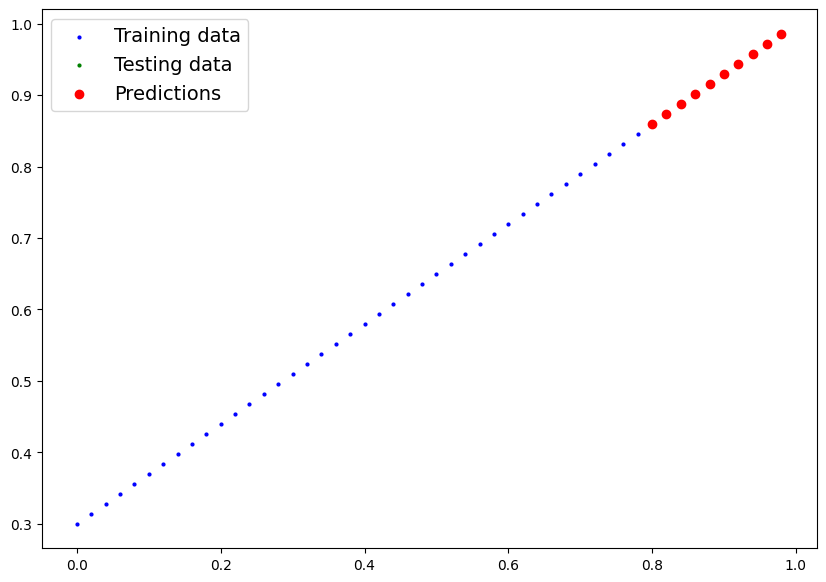

In [52]:
# plotting
import numpy as np
plot_predictions(predictions=y_preds.cpu())

### 6.5 Saving and loading model


In [54]:
## saving our model
from pathlib import Path

# create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# create a model save path
MODEL_NAME = '01_pytorch_workflow_model_1.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# save the model's state dict
print(f"saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f = MODEL_SAVE_PATH)

saving model to : models/01_pytorch_workflow_model_1.pth


In [55]:
# load a pytorch model
loaded_model_1 = LinearRegressionModelV2()

# load the saved model_1 state_dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# put loaded model to device
loaded_model_1.to(device)

<ipython-input-55-7b0e1a24353e>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))


LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [56]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [57]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [58]:
# eval loaded model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')